In [5]:
from hw_demo_estimation import etl, graph_manipulation as gm, data_viz as dv, data_manipulation as dm
from networkx.algorithms.assortativity import average_neighbor_degree
from networkx.algorithms.cluster import clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Demography Estimation Homework

This is a markdown cell in a jupyter notebook where I can write analysis about the charts and the statistics that I calculated

In [6]:
nodes, edges = etl.load_and_select_profiles_and_edges()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [7]:
G=gm.create_graph_from_nodes_and_edges(nodes, edges)

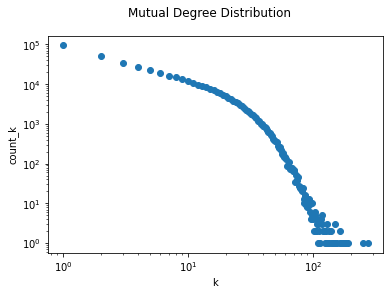

In [8]:
dv.plot_degree_distribution(G)

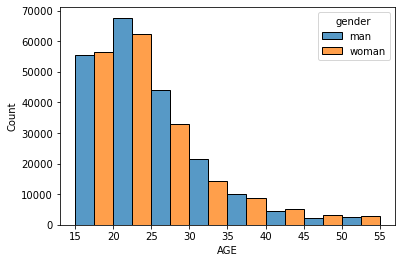

In [9]:
# descriptive analytics of the nodes
# age distribution by gender
dv.plot_age_distribution_by_gender(nodes)

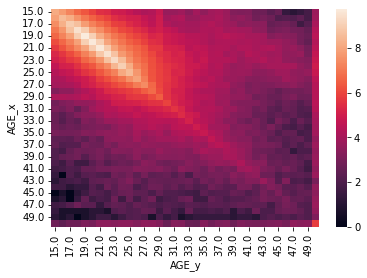

In [10]:
edges_w_features = gm.add_node_features_to_edges(nodes, edges)
dv.plot_age_relations_heatmap(edges_w_features)
# THE END

In [11]:
directed = dm.compute_directed_edges(edges_w_features)
predict = dm.add_nbrs_by_gender(nodes, directed)
predict.loc[predict["TRAIN_TEST"]=="TEST", "gender"] = 1.0
predict.loc[(predict["TRAIN_TEST"]=="TEST") & (predict["0_nbrs"]>predict["1_nbrs"]), "gender"] = 0.0

In [12]:
predict[predict["TRAIN_TEST"]=="TEST"]["gender"]

user_id
80         1.0
140        0.0
229        0.0
259        1.0
225        1.0
          ... 
1606117    1.0
1617662    0.0
1623716    1.0
1628486    0.0
1629774    1.0
Name: gender, Length: 24898, dtype: float64

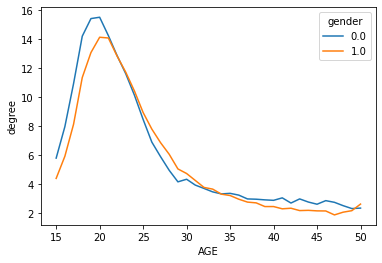

In [14]:
dv.plot_node_statistic_by_gender(nodes, dict(G.degree))

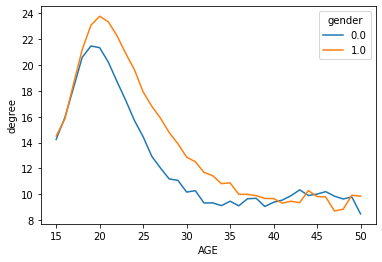

In [15]:
dv.plot_node_statistic_by_gender(nodes, average_neighbor_degree(G))

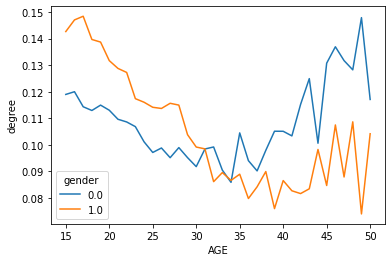

In [16]:
dv.plot_node_statistic_by_gender(nodes, clustering(G))

In [17]:
directed = directed.dropna()

<AxesSubplot:xlabel='AGE_x', ylabel='y_axis'>

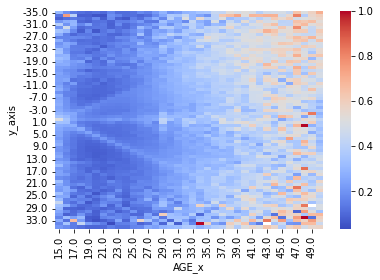

In [18]:
directed["weight"] = 1/directed["smaller_id"].map(dict(G.degree()))
directed[["gender_x", "gender_y"]] = directed[["gender_x", "gender_y"]].replace({0:-1})
directed["y_axis"] = directed["gender_y"]*(directed["AGE_y"]-15)
to_plot = directed.groupby(["AGE_x", "gender_x", "y_axis", "smaller_id"]).sum()["weight"]
to_plot = to_plot.groupby(["AGE_x", "gender_x", "y_axis"]).mean()

df = to_plot[to_plot.index.get_level_values("gender_x").isin([1.0])].groupby(["AGE_x", "y_axis"]).sum()
df = df.reset_index().pivot("y_axis", "AGE_x", "weight")

from seaborn import heatmap
heatmap(df, cmap="coolwarm")

<AxesSubplot:xlabel='AGE_x', ylabel='y_axis'>

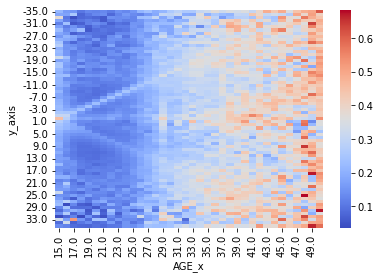

In [19]:
df = to_plot[to_plot.index.get_level_values("gender_x").isin([-1.0])].groupby(["AGE_x", "y_axis"]).sum()
df = df.reset_index().pivot("y_axis", "AGE_x", "weight")

heatmap(df, cmap="coolwarm")

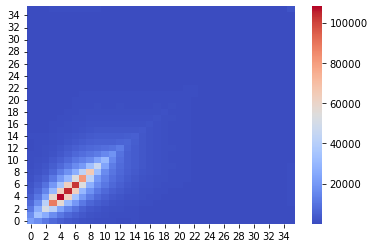

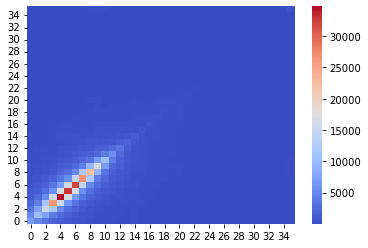

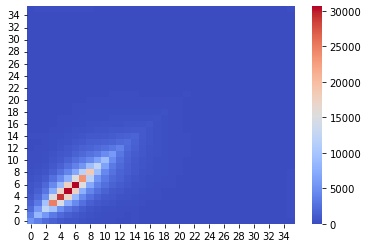

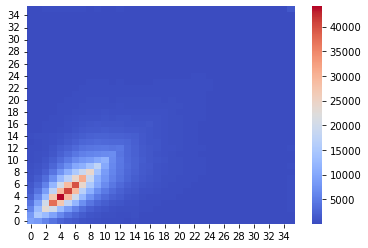

In [32]:
for indexer in [
    [True]*len(counter), # no filtering
    (counter["gender_x"]==0.0) & (counter["gender_y"]==0.0),
    (counter["gender_x"]==1.0) & (counter["gender_y"]==1.0),
    ((counter["gender_x"]==1.0) & (counter["gender_y"]==0.0)) | ((counter["gender_x"]==0.0) & (counter["gender_y"]==1.0))
]:
    plt.figure()
    counter["temp"] = 1.0
    arr = counter[indexer].groupby(["AGE_x", "AGE_y"]).sum()["temp"].reset_index().pivot("AGE_x", "AGE_y", "temp").fillna(0).to_numpy()
    arr = arr + arr.transpose()
    heatmap(arr, cmap="coolwarm").invert_yaxis()

In [ ]:
Ez az ábra azért más, mint a tanulmányban lévő, mert a gráfunkban súlyozatlan élek vannak

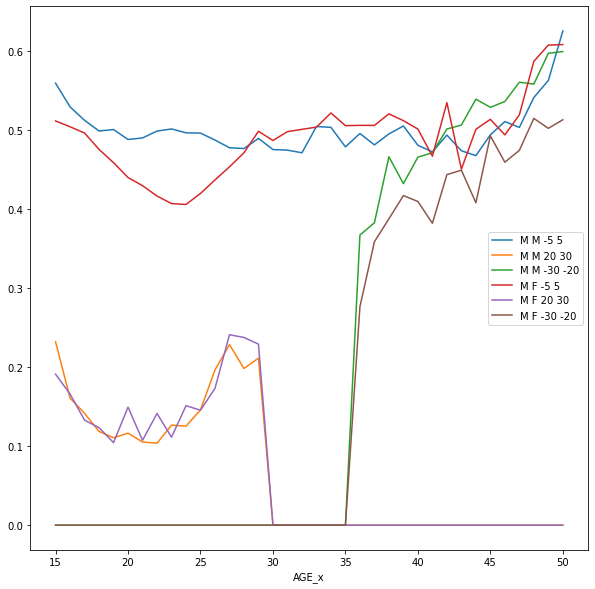

<Figure size 432x288 with 0 Axes>

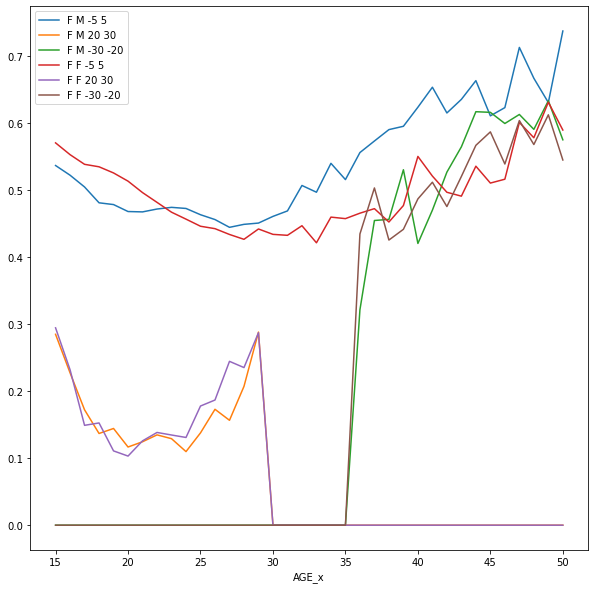

In [45]:
import pandas
directed = dm.compute_directed_edges(edges_w_features).dropna()
directed["weight"] = 1/directed["smaller_id"].map(dict(G.degree()))
directed["age_diff"] = directed["AGE_y"]-directed["AGE_x"]
df = pandas.DataFrame()
df["AGE_x"]=directed["AGE_x"].unique()
df = df.set_index("AGE_x")
gender = {0.0: "M", 1.0: "F"}

plot_idx = [[], []]
for g1 in [0, 1]:
    for g2 in [0.0, 1.0]:
        for lower, upper in [(-5, 5), (20, 30), (-30, -20)]:
                filtered = directed[(directed["gender_x"] == g1) & (directed["gender_y"] == g2) & (directed["age_diff"] > lower) & (directed["age_diff"] < upper) ]
                to_plot = filtered.groupby(["smaller_id", "AGE_x"]).sum()["weight"]
                to_plot = to_plot.groupby("AGE_x").mean().reset_index()
                to_plot = to_plot.set_index("AGE_x")
                name = " ".join([str(it) for it in [gender[g1], gender[g2], lower, upper]])
                plot_idx[g1].append(name)
                df[name] = to_plot["weight"]


df = df.fillna(0).sort_index()
df[plot_idx[0]].plot(figsize=(10, 10));
plt.figure()
df[plot_idx[1]].plot(figsize=(10, 10));

itt úgy tűnik, mintha a középső tartományból valamiért elvesztek volna az adatok

# 3.feladat

In [ ]:
from networkx import find_cliques
tris = [c for c in find_cliques(G) if len(c)==3]

In [ ]:
gender_tris = [[n.loc[it, "gender"] for it in tri ] for tri in tris]
keys = [(3, 0), (2, 1), (1, 2), (0, 3)]
distr = dict()
for key in keys:
    distr[key] = 0 
for tri in gender_tris:
    num_0 = tri.count(0)
    num_1 = tri.count(1)
    if (num_0, num_1) in keys:
        distr[(num_0, num_1)] +=1

In [ ]:
N = sum(distr.values())
for key in keys:
    distr[key] /= N
distr

A distr változó tartalmazza az ismert nemű csúcspontok alapján becsült eloszlását az egyes típusú háromszögeknek, ahol a típus alatt azt értjük, milyen nemből mennyit tartalmaz a háromszög. Feltételezve, hogy ezen eloszlás a teljes gráfra igaz maximum likelihood becslést végezhetünk az ismeretlen csúcsok nemére az alapján, hogy milyen típusú háromszögek jönnek létre, ha valamilyen neműnek vesszük az egyes csúcspontokat. Bár egyértelműen nem függetlenek egymástól a háromszögek típusa, ennek ellenére egy közelítő ML becslésként vehetjük a likelihoodot a létrejövő háromszögek valószínűségének a szorzatának. 